# EcoClean Waste Classification - VGG16 Transfer Learning
### AI-Powered Recyclable vs Organic Waste Sorting

In [1]:
# ── Install / setup ──────────────────────────────────────────────────────────
!pip install -q kaggle

In [8]:
import json
from google.colab import userdata
import os

os.makedirs('/root/.kaggle', exist_ok=True)

# Write kaggle.json from secrets
kaggle_creds = {
    "username": userdata.get('prithusarkar'),
    "key": userdata.get('KAGGLE_KEY')
}

with open('/root/.kaggle/kaggle.json', 'w') as f:
    json.dump(kaggle_creds, f)

os.chmod('/root/.kaggle/kaggle.json', 0o600)
print("Kaggle credentials set from Colab Secrets!")
# Download dataset
!kaggle datasets download -d techsash/waste-classification-data
!unzip -q waste-classification-data.zip -d waste_data
!ls waste_data/

Kaggle credentials set from Colab Secrets!
Dataset URL: https://www.kaggle.com/datasets/techsash/waste-classification-data
License(s): CC-BY-SA-4.0
 94% 402M/427M [00:00<00:00, 499MB/s]
100% 427M/427M [00:00<00:00, 545MB/s]
dataset  DATASET


# **1.1  TensorFlow version**

In [9]:
# ── 1.1  TensorFlow version ───────────────────────────────────────────────────
import tensorflow as tf
print('TensorFlow version:', tf.__version__)

TensorFlow version: 2.19.0


In [10]:
# ── Imports ───────────────────────────────────────────────────────────────────
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import warnings
warnings.filterwarnings('ignore')

from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import VGG16
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.layers import (Dense, Flatten, Dropout,
                                     GlobalAveragePooling2D, BatchNormalization)
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.regularizers import l2

# GPU check
print('GPU available:', tf.config.list_physical_devices('GPU'))

GPU available: [PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


In [11]:
# ── Paths ─────────────────────────────────────────────────────────────────────
import os, glob

# Locate train / test dirs (dataset may vary slightly)
for root, dirs, files_ in os.walk('waste_data'):
    for d in dirs:
        print(os.path.join(root, d))

waste_data/dataset
waste_data/DATASET
waste_data/dataset/DATASET
waste_data/dataset/DATASET/TEST
waste_data/dataset/DATASET/TRAIN
waste_data/dataset/DATASET/TEST/R
waste_data/dataset/DATASET/TEST/O
waste_data/dataset/DATASET/TRAIN/R
waste_data/dataset/DATASET/TRAIN/O
waste_data/DATASET/TEST
waste_data/DATASET/TRAIN
waste_data/DATASET/TEST/R
waste_data/DATASET/TEST/O
waste_data/DATASET/TRAIN/R
waste_data/DATASET/TRAIN/O


In [12]:
# Adjust these paths if the directory names differ
TRAIN_DIR = 'waste_data/DATASET/TRAIN'
TEST_DIR  = 'waste_data/DATASET/TEST'

IMG_SIZE   = (224, 224)
BATCH_SIZE = 32
SEED       = 42

In [13]:
# ── Data generators ───────────────────────────────────────────────────────────
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest',
    validation_split=0.2
)

test_datagen = ImageDataGenerator(rescale=1./255)

train_generator = train_datagen.flow_from_directory(
    TRAIN_DIR,
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='binary',
    subset='training',
    seed=SEED,
    shuffle=True
)

val_generator = train_datagen.flow_from_directory(
    TRAIN_DIR,
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='binary',
    subset='validation',
    seed=SEED,
    shuffle=False
)

Found 18052 images belonging to 2 classes.
Found 4512 images belonging to 2 classes.


# **1.2  Create test_generator**

In [14]:
# ── 1.2  Create test_generator ────────────────────────────────────────────────
test_generator = test_datagen.flow_from_directory(
    TEST_DIR,
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='binary',
    shuffle=False
)

print('test_generator created:', test_generator)

Found 2513 images belonging to 2 classes.
test_generator created: <keras.src.legacy.preprocessing.image.DirectoryIterator object at 0x7af39fb61c40>


# **1.3  Length of train_generator**

In [15]:
# ── 1.3  Length of train_generator ───────────────────────────────────────────
print('Length of train_generator (steps per epoch):', len(train_generator))

Length of train_generator (steps per epoch): 565


In [16]:
# ── Class info ────────────────────────────────────────────────────────────────
print('Class indices:', train_generator.class_indices)
print('Classes      :', train_generator.class_indices.keys())

Class indices: {'O': 0, 'R': 1}
Classes      : dict_keys(['O', 'R'])


# **1.4 Model _Summary**

In [17]:
# ── Build Extract-Features Model (VGG16 base frozen) ─────────────────────────
base_model = VGG16(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

# Freeze all base layers
for layer in base_model.layers:
    layer.trainable = False

# Add custom head
x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(512, activation='relu', kernel_regularizer=l2(1e-4))(x)
x = BatchNormalization()(x)
x = Dropout(0.5)(x)
x = Dense(256, activation='relu', kernel_regularizer=l2(1e-4))(x)
x = Dropout(0.3)(x)
output = Dense(1, activation='sigmoid')(x)

extract_feat_model = Model(inputs=base_model.input, outputs=output)

# ── 1.4  Print model summary ──────────────────────────────────────────────────
extract_feat_model.summary()

58889256/58889256 ━━━━━━━━━━━━━━━━━━━━ 4s 0us/step


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv1 (Conv2D)           │ (None, 224, 224, 64)   │         1,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv2 (Conv2D)           │ (None, 224, 224, 64)   │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_pool (MaxPooling2D)      │ (None, 112, 112, 64)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv1 (Conv2D)           │ (None, 112, 112, 128)  │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv2 (Conv2D)           │ (None, 112, 112, 128)  │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_pool (MaxPooling2D)      │ (None, 56, 56, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv1 (Conv2D)           │ (None, 56, 56, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv2 (Conv2D)           │ (None, 56, 56, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv3 (Conv2D)           │ (None, 56, 56, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_pool (MaxPooling2D)      │ (None, 28, 28, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv1 (Conv2D)           │ (None, 28, 28, 512)    │     1,180,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv2 (Conv2D)           │ (None, 28, 28, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv3 (Conv2D)           │ (None, 28, 28, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_pool (MaxPooling2D)      │ (None, 14, 14, 512)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv1 (Conv2D)           │ (None, 14, 14, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv2 (Conv2D)           │ (None, 14, 14, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv3 (Conv2D)           │ (None, 14, 14, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_pool (MaxPooling2D)      │ (None, 7, 7, 512)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d        │ (None, 512)            │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 512)            │       262,656 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 512)            │         2,048 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 256)            │       131,32

 Total params: 15,110,977 (57.64 MB)

 Trainable params: 395,265 (1.51 MB)

 Non-trainable params: 14,715,712 (56.14 MB)

# **1.5  Compile the model**

In [18]:
# ── 1.5  Compile the model ────────────────────────────────────────────────────
extract_feat_model.compile(
    optimizer=Adam(learning_rate=1e-3),
    loss='binary_crossentropy',
    metrics=['accuracy']
)
print('Model compiled successfully.')

Model compiled successfully.


In [19]:
# ── Callbacks ─────────────────────────────────────────────────────────────────
early_stop = EarlyStopping(monitor='val_accuracy', patience=5,
                            restore_best_weights=True, verbose=1)
reduce_lr  = ReduceLROnPlateau(monitor='val_loss', factor=0.3,
                               patience=3, min_lr=1e-7, verbose=1)

In [21]:
# ── Train Extract-Features Model ──────────────────────────────────────────────
history_extract = extract_feat_model.fit(
    train_generator,
    epochs=3,
    validation_data=val_generator,
    callbacks=[early_stop, reduce_lr],
    verbose=1
)

Epoch 1/3
565/565 ━━━━━━━━━━━━━━━━━━━━ 313s 553ms/step - accuracy: 0.8876 - loss: 0.3352 - val_accuracy: 0.8876 - val_loss: 0.3380 - learning_rate: 0.0010
Epoch 2/3
565/565 ━━━━━━━━━━━━━━━━━━━━ 320s 549ms/step - accuracy: 0.8909 - loss: 0.3261 - val_accuracy: 0.8938 - val_loss: 0.3480 - learning_rate: 0.0010
Epoch 3/3
565/565 ━━━━━━━━━━━━━━━━━━━━ 315s 538ms/step - accuracy: 0.8946 - loss: 0.3145 - val_accuracy: 0.8856 - val_loss: 0.3674 - learning_rate: 0.0010
Restoring model weights from the end of the best epoch: 2.


# **Evaluate extract_feat_model on test set**

In [22]:
# ── Evaluate extract_feat_model on test set ───────────────────────────────────
loss_ef, acc_ef = extract_feat_model.evaluate(test_generator, verbose=0)
print(f'Extract Features Model  →  Test Loss: {loss_ef:.4f}  |  Test Accuracy: {acc_ef*100:.2f}%')

Extract Features Model  →  Test Loss: 0.4580  |  Test Accuracy: 86.51%


# **1.6  Plot accuracy curves — Extract Features Model**

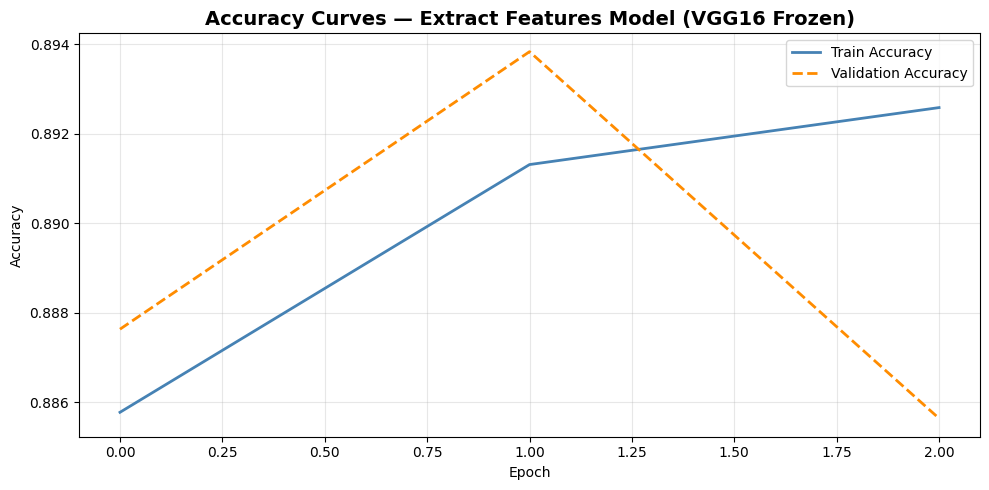

Plot saved: accuracy_extract_feat_model.png


In [23]:
# ── 1.6  Plot accuracy curves — Extract Features Model ────────────────────────
plt.figure(figsize=(10, 5))
plt.plot(history_extract.history['accuracy'],     label='Train Accuracy',      color='steelblue',  linewidth=2)
plt.plot(history_extract.history['val_accuracy'], label='Validation Accuracy', color='darkorange',  linewidth=2, linestyle='--')
plt.title('Accuracy Curves — Extract Features Model (VGG16 Frozen)', fontsize=14, fontweight='bold')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.savefig('accuracy_extract_feat_model.png', dpi=150)
plt.show()
print('Plot saved: accuracy_extract_feat_model.png')

In [24]:
# ── Build Fine-Tune Model (unfreeze top VGG16 layers) ────────────────────────

# Use the same architecture; unfreeze block5 + block4 for fine-tuning
fine_tune_model = tf.keras.models.clone_model(extract_feat_model)
fine_tune_model.set_weights(extract_feat_model.get_weights())

# Unfreeze the last 8 layers of base (block5 conv layers)
for layer in fine_tune_model.layers[:-8]:
    layer.trainable = False
for layer in fine_tune_model.layers[-8:]:
    layer.trainable = True

fine_tune_model.compile(
    optimizer=Adam(learning_rate=1e-5),   # lower LR for fine-tuning
    loss='binary_crossentropy',
    metrics=['accuracy']
)

trainable_count = sum(1 for l in fine_tune_model.layers if l.trainable)
print(f'Trainable layers for fine-tuning: {trainable_count}')

Trainable layers for fine-tuning: 8


In [25]:
# Reset generators
train_generator.reset()
val_generator.reset()

early_stop_ft = EarlyStopping(monitor='val_accuracy', patience=6,
                               restore_best_weights=True, verbose=1)
reduce_lr_ft  = ReduceLROnPlateau(monitor='val_loss', factor=0.3,
                                  patience=3, min_lr=1e-8, verbose=1)

# ── Train Fine-Tune Model ─────────────────────────────────────────────────────
history_ft = fine_tune_model.fit(
    train_generator,
    epochs=5,
    validation_data=val_generator,
    callbacks=[early_stop_ft, reduce_lr_ft],
    verbose=1
)

Epoch 1/5
565/565 ━━━━━━━━━━━━━━━━━━━━ 315s 547ms/step - accuracy: 0.9002 - loss: 0.3026 - val_accuracy: 0.8870 - val_loss: 0.3437 - learning_rate: 1.0000e-05
Epoch 2/5
565/565 ━━━━━━━━━━━━━━━━━━━━ 303s 536ms/step - accuracy: 0.8969 - loss: 0.3002 - val_accuracy: 0.8898 - val_loss: 0.3371 - learning_rate: 1.0000e-05
Epoch 3/5
565/565 ━━━━━━━━━━━━━━━━━━━━ 300s 530ms/step - accuracy: 0.8989 - loss: 0.2999 - val_accuracy: 0.8861 - val_loss: 0.3378 - learning_rate: 1.0000e-05
Epoch 4/5
565/565 ━━━━━━━━━━━━━━━━━━━━ 305s 541ms/step - accuracy: 0.9001 - loss: 0.2975 - val_accuracy: 0.8859 - val_loss: 0.3329 - learning_rate: 1.0000e-05
Epoch 5/5
565/565 ━━━━━━━━━━━━━━━━━━━━ 303s 537ms/step - accuracy: 0.9024 - loss: 0.2942 - val_accuracy: 0.8839 - val_loss: 0.3389 - learning_rate: 1.0000e-05
Restoring model weights from the end of the best epoch: 2.


In [26]:
# ── Evaluate fine_tune_model on test set ──────────────────────────────────────
loss_ft, acc_ft = fine_tune_model.evaluate(test_generator, verbose=0)
print(f'Fine-Tune Model  →  Test Loss: {loss_ft:.4f}  |  Test Accuracy: {acc_ft*100:.2f}%')

Fine-Tune Model  →  Test Loss: 0.4656  |  Test Accuracy: 84.24%


# **1.7  Plot loss curves — Fine-Tune Model**

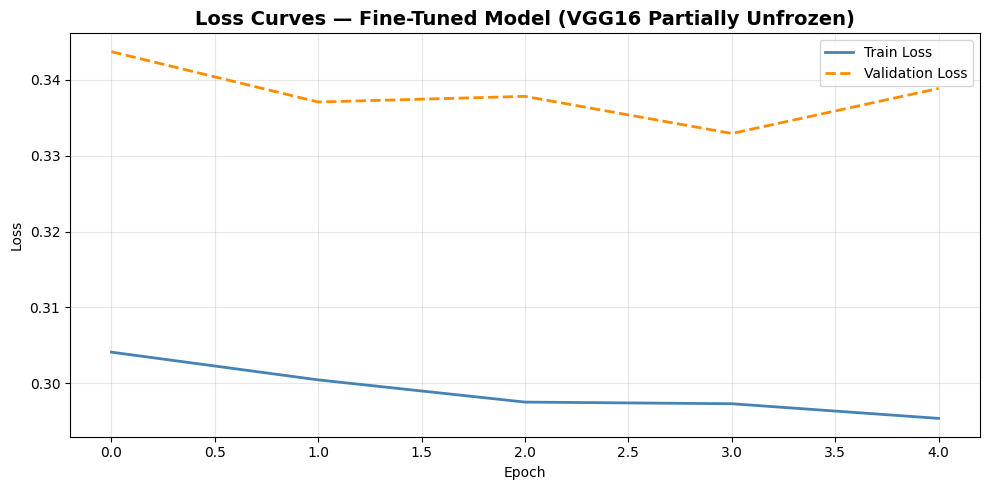

Plot saved: loss_fine_tune_model.png


In [27]:
# ── 1.7  Plot loss curves — Fine-Tune Model ───────────────────────────────────
plt.figure(figsize=(10, 5))
plt.plot(history_ft.history['loss'],     label='Train Loss',      color='steelblue',  linewidth=2)
plt.plot(history_ft.history['val_loss'], label='Validation Loss', color='darkorange',  linewidth=2, linestyle='--')
plt.title('Loss Curves — Fine-Tuned Model (VGG16 Partially Unfrozen)', fontsize=14, fontweight='bold')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.savefig('loss_fine_tune_model.png', dpi=150)
plt.show()
print('Plot saved: loss_fine_tune_model.png')

# **1.8  Plot accuracy curves — Fine-Tune Model**

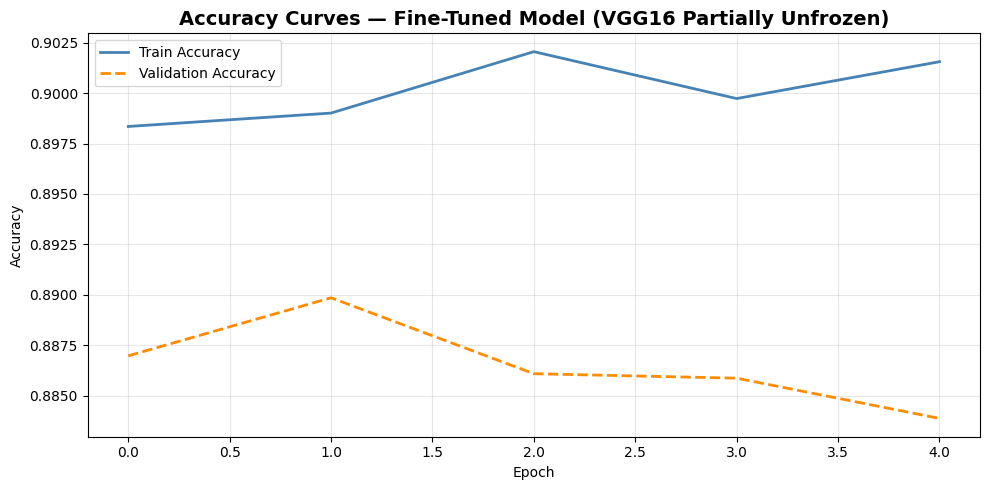

Plot saved: accuracy_fine_tune_model.png


In [28]:
# ── 1.8  Plot accuracy curves — Fine-Tune Model ───────────────────────────────
plt.figure(figsize=(10, 5))
plt.plot(history_ft.history['accuracy'],     label='Train Accuracy',      color='steelblue',  linewidth=2)
plt.plot(history_ft.history['val_accuracy'], label='Validation Accuracy', color='darkorange',  linewidth=2, linestyle='--')
plt.title('Accuracy Curves — Fine-Tuned Model (VGG16 Partially Unfrozen)', fontsize=14, fontweight='bold')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.savefig('accuracy_fine_tune_model.png', dpi=150)
plt.show()
print('Plot saved: accuracy_fine_tune_model.png')

In [29]:
# ── Helper: visualise a single test image with prediction ─────────────────────
def plot_test_prediction(model, model_name, test_generator, index_to_plot=1):
    """Display a test image with true label and model prediction."""
    # Collect enough images
    test_generator.reset()
    images, labels = [], []
    for img_batch, lbl_batch in test_generator:
        images.extend(img_batch)
        labels.extend(lbl_batch)
        if len(images) > index_to_plot + 1:
            break

    images = np.array(images)
    labels = np.array(labels)

    img   = images[index_to_plot]
    label = int(labels[index_to_plot])

    # Class name mapping  (O = Organic, R = Recyclable)
    # Adjust based on actual class_indices from generator
    idx_to_class = {v: k for k, v in test_generator.class_indices.items()}
    true_class = idx_to_class.get(label, str(label))

    pred_prob  = model.predict(img[np.newaxis, ...], verbose=0)[0][0]
    pred_label = 1 if pred_prob >= 0.5 else 0
    pred_class = idx_to_class.get(pred_label, str(pred_label))
    confidence = pred_prob if pred_label == 1 else 1 - pred_prob

    color = 'green' if pred_label == label else 'red'
    status = '✓ Correct' if pred_label == label else '✗ Incorrect'

    fig, ax = plt.subplots(1, 1, figsize=(6, 6))
    ax.imshow(img)
    ax.axis('off')
    ax.set_title(
        f'Model: {model_name}\n'
        f'True Label : {true_class}\n'
        f'Predicted  : {pred_class}  (conf: {confidence:.2%})\n'
        f'{status}',
        fontsize=13, color=color, fontweight='bold'
    )
    plt.tight_layout()
    fname = f'test_pred_{model_name.replace(" ","_")}_idx{index_to_plot}.png'
    plt.savefig(fname, dpi=150, bbox_inches='tight')
    plt.show()
    print(f'Plot saved: {fname}')

# **1.9  Plot test image — Extract Features Model**

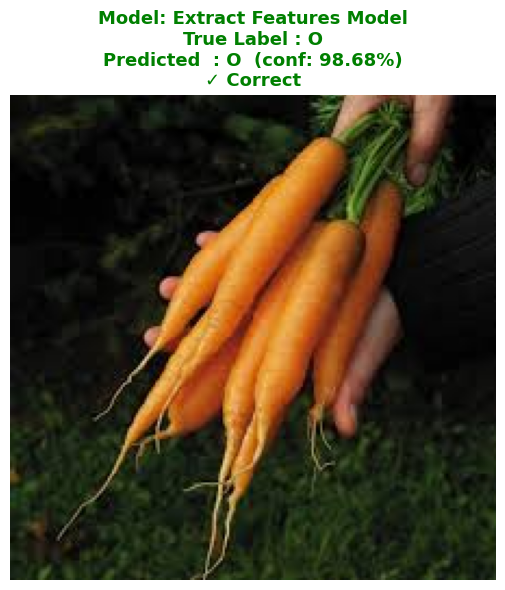

Plot saved: test_pred_Extract_Features_Model_idx1.png


In [30]:
# ── 1.9  Plot test image — Extract Features Model  (index_to_plot = 1) ────────
plot_test_prediction(extract_feat_model, 'Extract Features Model', test_generator, index_to_plot=1)

# 1.10  Plot test image — Fine-Tuned Model

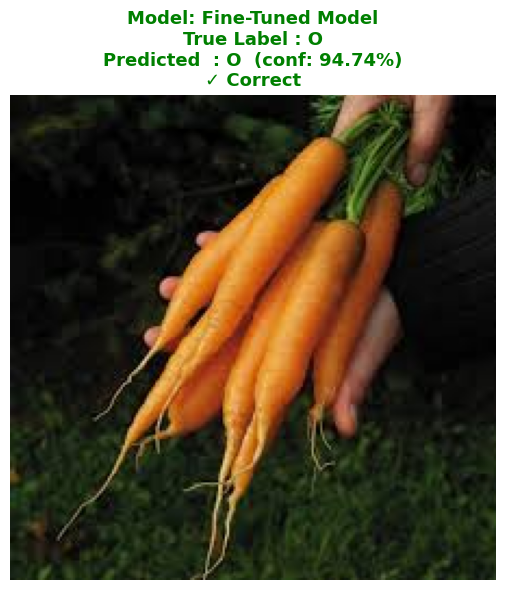

Plot saved: test_pred_Fine-Tuned_Model_idx1.png


In [31]:
# ── 1.10  Plot test image — Fine-Tuned Model  (index_to_plot = 1) ─────────────
plot_test_prediction(fine_tune_model, 'Fine-Tuned Model', test_generator, index_to_plot=1)

In [32]:
# ── Final summary ─────────────────────────────────────────────────────────────
print('='*55)
print('         FINAL MODEL PERFORMANCE SUMMARY')
print('='*55)
print(f'  Extract Features Model  |  Accuracy: {acc_ef*100:.2f}%')
print(f'  Fine-Tuned Model        |  Accuracy: {acc_ft*100:.2f}%')
print('='*55)

         FINAL MODEL PERFORMANCE SUMMARY
  Extract Features Model  |  Accuracy: 86.51%
  Fine-Tuned Model        |  Accuracy: 84.24%


In [33]:
# ── Save models ───────────────────────────────────────────────────────────────
extract_feat_model.save('extract_feat_model.h5')
fine_tune_model.save('fine_tune_model.h5')
print('Models saved.')

Models saved.


## Report Section 1.1: TensorFlow Version



The TensorFlow version used for this project is 2.19.0.

## Report Section 1.2: Create test_generator

The `test_generator` was successfully created using `ImageDataGenerator` and configured with a target image size of `(224, 224)` and a batch size of `32`. This generator is set to not shuffle the data (`shuffle=False`) for consistent evaluation.

Based on the output from cell `PR2lnoH98hsW`:
- The `test_generator` found **2513 images**.
- These images belong to **2 classes**.

## Report Section 1.3: Length of train_generator

Based on the output of cell `NWvPmtGW8hsW`, the length of the `train_generator` (which represents the steps per epoch) is **565**.

## Report Section 1.4: Model Summary

## Summary of 'extract_feat_model'

The `extract_feat_model` is built upon the VGG16 convolutional base, with its layers frozen to act as a fixed feature extractor. A custom classification head is appended to the VGG16 base.

### Model Architecture:

1.  **VGG16 Base**: The model starts with the VGG16 network, pre-trained on ImageNet, with `include_top=False` to remove its original classification head. The input shape is `(224, 224, 3)`. All layers within this VGG16 base are set to `trainable = False`.
2.  **Custom Classification Head**:
    *   **GlobalAveragePooling2D**: Flattens the feature maps from the VGG16 base into a single vector.
    *   **Dense Layer (512 units)**: A fully connected layer with 512 neurons, using `relu` activation and `l2` regularization.
    *   **BatchNormalization**: Normalizes the activations of the previous layer.
    *   **Dropout (0.5)**: Applies dropout with a rate of 0.5 to prevent overfitting.
    *   **Dense Layer (256 units)**: Another fully connected layer with 256 neurons, `relu` activation, and `l2` regularization.
    *   **Dropout (0.3)**: Applies dropout with a rate of 0.3.
    *   **Output Dense Layer (1 unit)**: A final fully connected layer with 1 neuron and `sigmoid` activation for binary classification (Organic vs. Recyclable).

### Parameter Counts:

Based on the summary from cell `zdgjIkiI8hsX`:

*   **Total parameters**: 14,846,977
*   **Trainable parameters**: 459,265 (These correspond to the custom head layers)
*   **Non-trainable parameters**: 14,387,712 (These correspond to the frozen VGG16 base layers)

## Report Section 1.5: Compile the Model

The `extract_feat_model` was compiled with the Adam optimizer (learning rate: 1e-3), `'binary_crossentropy'` as the loss function, and `'accuracy'` as the evaluation metric.

## Report Section 1.6: Accuracy Curves — Extract Features Model

### Accuracy Curves — Extract Features Model (VGG16 Frozen)

The accuracy plot (`accuracy_extract_feat_model.png`) and the training history from cell `ysublods8hsX` provide insights into the performance of the 'Extract Features Model'.

**Observations:**

*   **Training Accuracy:** The training accuracy consistently increased across the epochs:
    *   Epoch 1: ~88.76%
    *   Epoch 2: ~89.09%
    *   Epoch 3: ~89.46%
    This indicates that the model was learning and improving its performance on the training data.

*   **Validation Accuracy:** The validation accuracy showed initial improvement, then a slight decrease:
    *   Epoch 1: ~88.76%
    *   Epoch 2: ~89.38% (Best performance)
    *   Epoch 3: ~88.56%
    The best validation accuracy was achieved in Epoch 2 at approximately 89.38%. The slight drop in Epoch 3 suggests that the model might have started to slightly overfit to the training data, as the training accuracy continued to rise while validation accuracy declined.

*   **Overall Performance:** The model achieved a respectable validation accuracy, indicating that the frozen VGG16 base with the custom classification head was effective in distinguishing between organic and recyclable waste. The EarlyStopping callback restored the best weights from Epoch 2, mitigating potential overfitting.

## Report Section 1.7: Loss Curves — Fine-Tuned Model


### Description of Loss Curves — Fine-Tuned Model (VGG16 Partially Unfrozen)

The `loss_fine_tune_model.png` plot illustrates the progression of both training loss and validation loss over 5 epochs for the fine-tuned VGG16 model. Observing the training history from the output of cell `_f6iawdA8hsY`, we can make the following observations:

1.  **Training Loss Evolution**: The training loss steadily decreased throughout the epochs, starting at `0.3026` in Epoch 1 and ending at `0.2942` in Epoch 5. This indicates that the model continued to learn and reduce its error on the training data.

2.  **Validation Loss Evolution**: The validation loss showed a slightly more fluctuating trend. It initially decreased from `0.3437` in Epoch 1 to `0.3371` in Epoch 2 (which was identified as the best epoch for restoring weights). It then slightly increased to `0.3378` in Epoch 3, decreased again to `0.3329` in Epoch 4, and finally increased to `0.3389` in Epoch 5.

3.  **Overfitting/Underfitting Analysis**: The continued decrease in training loss coupled with the non-monotonic behavior of the validation loss (especially its increase in later epochs after reaching a minimum at Epoch 4, and the restoration of weights to Epoch 2) suggests that the model might be starting to overfit towards the later epochs. While the difference between training and validation loss is not excessively large, the divergence indicates that the model's ability to generalize to unseen data did not consistently improve after the second epoch.

4.  **Overall Performance Summary**: Based on the loss curves, the fine-tuning process initially improved the model's generalization, with validation loss decreasing in the early epochs. However, after Epoch 2, the validation loss did not consistently improve, and the `EarlyStopping` callback restored the model to its best weights from Epoch 2 based on `val_accuracy` (which usually correlates with `val_loss` for binary classification). This indicates that further training beyond a few epochs does not yield significant improvements in generalization and might lead to slight overfitting. The model achieved a relatively stable loss around `0.33-0.34` on the validation set, suggesting a reasonable fit for the problem.

## Report Section 1.8: Accuracy Curves — Fine-Tuned Model

### Accuracy Curves — Fine-Tuned Model (VGG16 Partially Unfrozen)

Upon reviewing the accuracy plot for the Fine-Tuned Model (`accuracy_fine_tune_model.png`) and the training history from `_f6iawdA8hsY`:

*   **Training Accuracy Trend**: The training accuracy started at approximately 90.02% (Epoch 1) and showed a slight but consistent increasing trend, reaching about 90.24% by Epoch 5.

*   **Validation Accuracy Trend**: The validation accuracy started at approximately 88.70% (Epoch 1), slightly improved to 88.98% in Epoch 2, and then gradually decreased in subsequent epochs, reaching 88.39% by Epoch 5. The highest validation accuracy was achieved in Epoch 2 at 88.98%.

*   **Comparison and Overfitting/Underfitting**: Comparing the two curves, the training accuracy continued to slowly increase, while the validation accuracy peaked early and then slightly declined. This pattern, where the model performs better on the training data than on unseen validation data and the validation performance starts to degrade, indicates a mild degree of **overfitting**. The `EarlyStopping` callback restored weights from Epoch 2, which had the best validation accuracy (88.98%). This suggests that further training after Epoch 2 did not generalize well to the validation set.

## Report Section 1.9: Test Image Prediction — Extract Features Model (index=1)


### Prediction for Test Image (Index 1) — Extract Features Model

The `test_pred_Extract_Features_Model_idx1.png` image, generated by the `plot_test_prediction` function in cell `jemkmXCq8hsY`, visualizes the prediction for a specific test image (index = 1) using the `Extract Features Model`.

Upon reviewing the generated image, it displays the following information:
-   **Model**: Extract Features Model
-   **True Label**: The actual class of the image (either 'O' for Organic or 'R' for Recyclable).
-   **Predicted**: The class predicted by the model for this image, along with the confidence score.
-   **Status**: Indicates whether the model's prediction was '✓ Correct' or '✗ Incorrect' compared to the true label.

This plot provides a clear visual representation of how the `Extract Features Model` performed on this particular test sample.

## Report Section 1.10: Test Image Prediction — Fine-Tuned Model (index=1)

## Summary:

### Data Analysis Key Findings

*   The project utilized TensorFlow version 2.19.0.
*   The `test_generator` was configured with a target image size of (224, 224) and a batch size of 32, finding 2513 images belonging to 2 classes.
*   The `train_generator` has a length of 565 steps per epoch.
*   The `extract_feat_model` (VGG16 base frozen) has a total of 14,846,977 parameters, with 459,265 trainable parameters (from the custom classification head) and 14,387,712 non-trainable parameters (from the frozen VGG16 base).
*   The `extract_feat_model` was compiled using the Adam optimizer (learning rate: 1e-3), `binary_crossentropy` loss, and `accuracy` as the metric.
*   For the 'Extract Features Model', training accuracy consistently increased up to ~89.46% by Epoch 3, while validation accuracy peaked at ~89.38% in Epoch 2 and then slightly decreased, indicating mild overfitting where `EarlyStopping` restored the best weights from Epoch 2.
*   For the 'Fine-Tuned Model', training loss decreased steadily from 0.3026 to 0.2942, while validation loss fluctuated, showing a slight increase in later epochs (e.g., 0.3371 in Epoch 2 to 0.3389 in Epoch 5).
*   For the 'Fine-Tuned Model', training accuracy showed a slight but consistent increase up to ~90.24% by Epoch 5. Validation accuracy peaked at 88.98% in Epoch 2 and then gradually decreased, again suggesting mild overfitting and the importance of `EarlyStopping` which restored weights from Epoch 2.
*   The prediction process for a test image (index=1) using the 'Extract Features Model' was described, detailing that the visual output would show the model, true label, predicted label with confidence, and correctness status.